# 7-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

목차

1) 데이터 준비와 확인  
2) 데이터로더 구성  
3) 모델구성을 위한 데이터 분석 및 가공  
4) 모델구성 및 validation set 구성  
5) 모델 훈련 개시  
6) Loss, Accuracy 그래프 시각화  
7) 학습된 Embedding 레이어 분석  
8) 한국어 Word2Vec 임베딩 활용하여 성능개선  
9) 마무리 및 회고

## 1) 데이터 준비와 확인

활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된
Naver sentiment movie corpus (https://github.com/e9t/nsmc) 입니다.

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 부정적인 리뷰는 0으로, 긍정적인 리뷰는 1로 분류 하였음을 알 수 있습니다.

## 2) 데이터로더 구성
---
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.

그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any') # NA 값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any') # NA 값 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   # concatenate 는 합치는 것, 리스트 안에 리스트 있는 걸 플랫하게, ex. [[1,2][3,4]] -> [1,2,3,4]로
    counter = Counter(words)
    counter = counter.most_common(10000-4)   # 10000-4 를 하는 이유? 앞에 빈칸 4개를 제외하고 9996개를 뽑아내는 거
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# train data 의 길이를 살펴보고, word_to_index의 길이와 자료형을 확인해봅니다.
print(len(X_train))
print(len(y_train)) 

146182
146182


In [6]:
# test data 의 길이
print(len(X_test))
print(len(y_test))

49157
49157


In [7]:
print('word_to_index : ',len(word_to_index), type(word_to_index))

word_to_index :  9997 <class 'dict'>


- word_to_index에는 어떤 내용이 들어있는지 확인한다.
- word_to_index는 word:index 형태로 묶인 데이터들의 집합이다.
- 파이썬 프로그래밍의 index는 0부터 시작이다.
- 확인해 보면, 앞쪽에 있어야 할 PAD, BOS, UNK가 나타나지 않았음을 알 수 있다. 이들을 각각 index 0, 1, 2로 대응시켜 딕셔너리에 포함시킨다.

In [8]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [9]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [10]:
# index : 단어(키 : 값) 형태의 딕셔너리 생셩
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
print("X_train len: ", len(X_train))
print("X_test len: ", len(X_test))

X_train len:  146182
X_test len:  49157


In [13]:
# index 첫 번째 값 Encoded, Decoded, Label 값 확인
print("Encoded Sentence: ", X_train[0])
print("Decoded Sentence: ", get_decoded_sentence(X_train[0], index_to_word)) 
print("Label(0, 1): ", y_train[0])
print('1번째 리뷰 문장 길이: ', len(X_train[0]))

Encoded Sentence:  [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Decoded Sentence:  더 빙 . . 진짜 짜증 나 네요 목소리
Label(0, 1):  0
1번째 리뷰 문장 길이:  10


In [14]:
# index 10 번째 값 Encoded, Decoded, Label 값 확인
print("Encoded Sentence: ", X_train[9])
print("Decoded Sentence: ", get_decoded_sentence(X_train[9], index_to_word))
print("Label(0, 1): ", y_train[9])
print('10번째 리뷰 문장 길이: ', len(X_train[9]))

Encoded Sentence:  [63, 656, 58, 240, 760, 18, 574, 89, 3, 4, 4, 1482, 637, 736, 81, 22, 24, 3, 16, 20, 18]
Decoded Sentence:  케 평점 낮 건데 ? 꽤 볼  . . 헐리우드 식 화려 함 만 너무  있 나 ?
Label(0, 1):  1
10번째 리뷰 문장 길이:  21


## 3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 전체 데이터셋의 분포 확인

In [15]:
# 테스트 데이터
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있네요! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575% 정도가 maxlen 설정값 이내에 포함되어 있네요! 


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.98170773419436


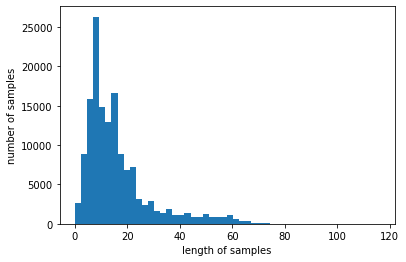

In [16]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# padding을 통해 문장의 길이를 맞춘다.

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다.

- 문장의 길이를 padding 을 이용하여 맞춤

In [18]:
x_train[0]

array([ 32,  74, 919,   4,   4,  39, 228,  20,  33, 748,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [19]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(136182, 41)
(136182,)
(10000, 41)
(10000,)


- train set을 분리하여 일부를 validation set으로 사용
- 총 145791개의 train set 중, 10000개를 validation set으로 분리

## 4) 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

1. Convolution Neural Network (1-D CNN) 모델
2. GlobalMaxPooling
3. LSTM

In [20]:
# 우선, 단어 사전의 크기를 지정해주고 한 단어를 표현하는 임베딩 벡터의 차원의 개수를 설정해준다.

vocab_size = 10000  # 단어 사전의 크기를 지정
word_vector_dim = 16  # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

이제 각 모델을 구성하고 학습시킨 다음 평가를 실시한다.
평가 후에는 각 모델의 Accuracy, Loss 그래프를 시각화하여 나타낸다.

### 4-1. Convolution Neural Network (1-D CNN) 모델

In [21]:
# 1-D CNN 모델 구성

model = keras.Sequential(name='CNN')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9       

### 4-2. GlobalMaxPooling 모델

In [25]:
# GlobalMaxPooling 모델 구성

model = keras.Sequential(name='GlobalMaxPooling')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "GlobalMaxPooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 4-3. LSTM

LSTM 은 RNN 중에서 가장 널리 쓰이는 모델로서, LSTM은 어떤 옵티마이저가 적합한지에 대해서는 명확한 정답이 없습니다.

간단히 말해 데이터셋에 따라 옵티마이저 성능이 달라지며, 경사 소실 문제와 경사 증폭 문제(exploding gradient problem) 떄문에 특정 옵티마이저가 데이터셋을 제대로 학습하지 못하는 경우가 있습니다.

어떤 옵티마이저가 가장 좋은지 알아내는 방법으로는 여러 옵티마이저를 적용해 모델을 여러 개 훈련시키고 성능을 비교하는 것입니다.

비교 할 옵티마이저
- sgd
- adam
- RMSprop

In [28]:
# LSTM 모델 형성
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

# Optimizer를 인수로 받는 train_model() 함수
def train_model(Optimizer, X_train, y_train, X_val, y_val):
    model = keras.Sequential()
    model.add(Embedding(input_dim=10000, output_dim=16))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Optimizer,
                  metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=512,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       verbose=1)
    return scores, model

## 5) 모델 훈련 개시
---

In [22]:
# 1-D CNN 모델 훈련

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 9s 20ms/step - loss: 0.5937 - accuracy: 0.6611 - val_loss: 0.3489 - val_accuracy: 0.8468
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3248 - accuracy: 0.8638 - val_loss: 0.3351 - val_accuracy: 0.8530
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2933 - accuracy: 0.8789 - val_loss: 0.3371 - val_accuracy: 0.8505
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2710 - accuracy: 0.8898 - val_loss: 0.3384 - val_accuracy: 0.8542
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2397 - accuracy: 0.9061 - val_loss: 0.3498 - val_accuracy: 0.8478
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2115 - accuracy: 0.9205 - val_loss: 0.3658 - val_accuracy: 0.8455
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1834 - accuracy: 0.9334 - val_loss: 0.3966 - val_accuracy: 0.8439
Epoch

In [25]:
# GlobalMaxPooling 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 8ms/step - loss: 0.0952 - accuracy: 0.9697 - val_loss: 0.5658 - val_accuracy: 0.8323
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0808 - accuracy: 0.9761 - val_loss: 0.6133 - val_accuracy: 0.8272
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0688 - accuracy: 0.9794 - val_loss: 0.6718 - val_accuracy: 0.8251
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0656 - accuracy: 0.9799 - val_loss: 0.7127 - val_accuracy: 0.8253
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0572 - accuracy: 0.9835 - val_loss: 0.7736 - val_accuracy: 0.8226
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0521 - accuracy: 0.9851 - val_loss: 0.8284 - val_accuracy: 0.8223
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0501 - accuracy: 0.9853 - val_loss: 0.8204 - val_accuracy: 0.8211
Epoch 

#### (1) LSTM + sgd

In [29]:
# LSTM + sgd 모델 학습
sgd_score, SGD_model = train_model(Optimizer='sgd',
                                   X_train=partial_x_train,
                                   y_train=partial_y_train,
                                   X_val=x_val,
                                   y_val=y_val)

Epoch 1/10
266/266 [==============================] - 8s 25ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/10
266/266 [==============================] - 6s 23ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 3/10
266/266 [==============================] - 6s 23ms/step - loss: 0.6931 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 4/10
266/266 [==============================] - 6s 23ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 5/10
266/266 [==============================] - 7s 25ms/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5027
Epoch 6/10
266/266 [==============================] - 6s 23ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/10
266/266 [==============================] - 6s 23ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5027

#### (2) LSTM + adam

In [32]:
# LSTM + adam 모델 학습
adam_score, adam_model = train_model(Optimizer='adam',
                                   X_train=partial_x_train,
                                   y_train=partial_y_train,
                                   X_val=x_val,
                                   y_val=y_val)

Epoch 1/10
266/266 [==============================] - 8s 24ms/step - loss: 0.5864 - accuracy: 0.6299 - val_loss: 0.3758 - val_accuracy: 0.8429
Epoch 2/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3443 - accuracy: 0.8544 - val_loss: 0.3453 - val_accuracy: 0.8509
Epoch 3/10
266/266 [==============================] - 6s 23ms/step - loss: 0.3188 - accuracy: 0.8658 - val_loss: 0.3514 - val_accuracy: 0.8495
Epoch 4/10
266/266 [==============================] - 6s 23ms/step - loss: 0.3067 - accuracy: 0.8700 - val_loss: 0.3399 - val_accuracy: 0.8539
Epoch 5/10
266/266 [==============================] - 6s 23ms/step - loss: 0.2905 - accuracy: 0.8783 - val_loss: 0.3434 - val_accuracy: 0.8455
Epoch 6/10
266/266 [==============================] - 6s 23ms/step - loss: 0.2824 - accuracy: 0.8818 - val_loss: 0.3497 - val_accuracy: 0.8535
Epoch 7/10
266/266 [==============================] - 6s 22ms/step - loss: 0.2634 - accuracy: 0.8906 - val_loss: 0.3397 - val_accuracy: 0.8559

#### (3) LSTM + RMSProp

In [35]:
# LSTM + RMSProp 모델 학습
RMSprop_score, RMSprop_model = train_model(Optimizer='RMSprop',
                                   X_train=partial_x_train,
                                   y_train=partial_y_train,
                                   X_val=x_val,
                                   y_val=y_val)

Epoch 1/10
266/266 [==============================] - 8s 25ms/step - loss: 0.5450 - accuracy: 0.7026 - val_loss: 0.4250 - val_accuracy: 0.8052
Epoch 2/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3670 - accuracy: 0.8437 - val_loss: 0.3666 - val_accuracy: 0.8429
Epoch 3/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3464 - accuracy: 0.8541 - val_loss: 0.3471 - val_accuracy: 0.8509
Epoch 4/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3275 - accuracy: 0.8624 - val_loss: 0.3337 - val_accuracy: 0.8540
Epoch 5/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3115 - accuracy: 0.8694 - val_loss: 0.3376 - val_accuracy: 0.8565
Epoch 6/10
266/266 [==============================] - 6s 22ms/step - loss: 0.3029 - accuracy: 0.8745 - val_loss: 0.3271 - val_accuracy: 0.8572
Epoch 7/10
266/266 [==============================] - 6s 22ms/step - loss: 0.2943 - accuracy: 0.8781 - val_loss: 0.3393 - val_accuracy: 0.8585

In [24]:
# test set을 이용해서 1-D CNN 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5150 - accuracy: 0.8327
[0.5149632096290588, 0.8327400088310242]


### -> 1-D CNN 모델 평과 결과 : 0.8322

In [27]:
# test set을 이용해서 GlobalMaxPooling 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9377 - accuracy: 0.8158
[0.9376779198646545, 0.8157739639282227]


### -> GlobalMaxPooling 모델 평가 결과 : 0.8391

In [31]:
# test set을 이용해서 LSTM + sgd 모델 평가
results = SGD_model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.6931 - accuracy: 0.4973
[0.6931410431861877, 0.4973045587539673]


### -> LSTM + sgd 모델 결과 : 0.4973

In [34]:
# test set을 이용해서 LSTM + adam 모델 평가
results = adam_model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3701 - accuracy: 0.8475
[0.3701377511024475, 0.8474886417388916]


### -> LSTM + adam 모델 평가 결과 : 0.8475

In [37]:
# test set을 이용해서 LSTM + RMSProp 모델 평가
results = RMSprop_model.evaluate(x_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3494 - accuracy: 0.8549
[0.34937790036201477, 0.8548731803894043]


### -> LSTM + RMSProp 모델 평가 결과 : 0.8549

- LSTM 에서 여러 옵티마이저 (sgd, adam, RMSprop) 로 모델을 돌려본 결과 RMSprop의 결과가 가장 좋게 나왔음을 확인 할 수 있었습니다.
- 영화 리뷰 분류 문제에서 LSTM 모델의 옵티마이저는 RMSprop로 선택하면 될 거 같습니다.

결과적으로 각 모델의 평가 결과를 높은 순으로 나열을 해보자면,

**LSTM + RMSProp 모델 (0.8549) > LSTM + adam 모델 (0.8475) > GlobalMaxPooling 모델 (0.8391) > CNN 모델 (0.8322) > LSTM + sgd 모델 (0.4973)** 으로 

나열 할 수 있습니다.

## 6) Loss, Accuracy 그래프 시각화
---

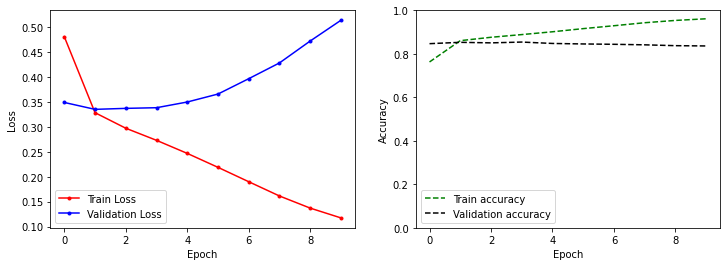

In [23]:
# 1-D CNN 모델 Loss, Accuracy 그래프 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

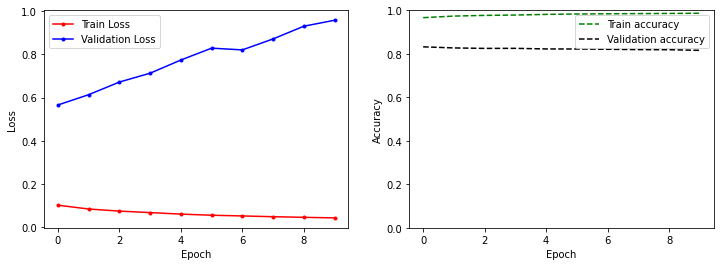

In [26]:
# GlobalMaxPooling 모델 Loss, Accuracy 그래프 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

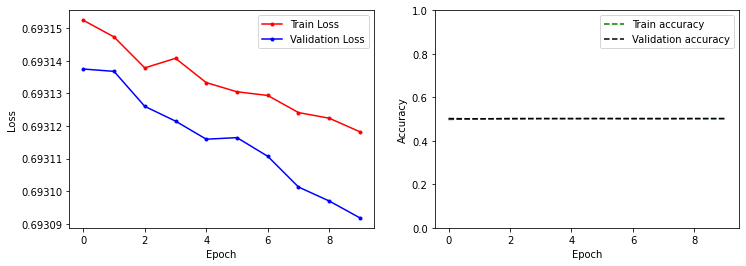

In [30]:
# LSTM + sgd 모델 Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(sgd_score.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(sgd_score.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_score.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(sgd_score.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

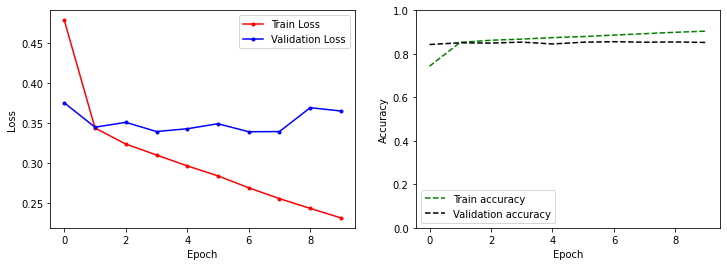

In [33]:
# LSTM + adam 모델 Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(adam_score.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(adam_score.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(adam_score.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(adam_score.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

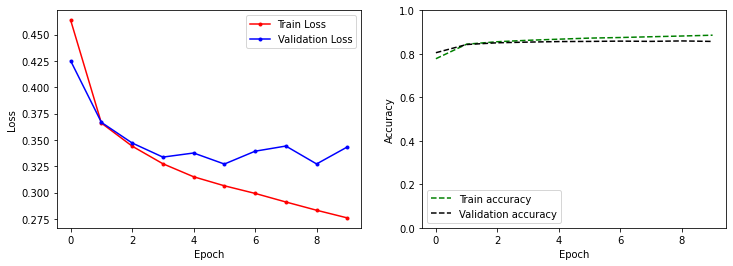

In [36]:
# LSTM + RMSProp 모델 Loss, Accuracy 그래프 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(RMSprop_score.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(RMSprop_score.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(RMSprop_score.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(RMSprop_score.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석
---

In [38]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [39]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [41]:
vector = word_vectors['만족']
vector

array([-0.11072786,  0.05379741,  0.00212593,  0.16335756, -0.05331237,
        0.17680244, -0.01319755, -0.0581025 ,  0.04871333,  0.02727831,
        0.12236284, -0.19322275, -0.02211848,  0.17476739,  0.16983828,
       -0.03195643], dtype=float32)

In [42]:
word_vectors.similar_by_word("놀람")

[('어떡', 0.7876429557800293),
 ('별거', 0.7515311241149902),
 ('정말로', 0.7235612869262695),
 ('b', 0.7087869048118591),
 ('챙기', 0.6971563100814819),
 ('슈', 0.6949559450149536),
 ('불러', 0.6807700395584106),
 ('처음', 0.6790968775749207),
 ('naver', 0.6748257875442505),
 ('류승범', 0.6661200523376465)]

In [62]:
word_vectors.similar_by_word("사랑")

[('용기', 0.842232882976532),
 ('케이트', 0.8357062935829163),
 (".'", 0.8295941352844238),
 ('박평식', 0.8257520198822021),
 ('대런', 0.8182333111763),
 ('넘버원', 0.7996325492858887),
 ('저격', 0.7939962148666382),
 ('출근', 0.7927019596099854),
 ('58', 0.7920931577682495),
 ('덴젤워싱턴', 0.7910977005958557)]

### Word2Vec 시각화(t-SNE, PCA)

최근에 사진에서 적용해보지 못한 t-SNE와 PCA 가 궁금해서 추가적으로 알아보아 시각화를 진행해 보았습니다.

참고링크 (https://joyhong.tistory.com/133)

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams["axes.unicode_minus"] = False

plt.rc('font', family='NanumBarunGothic') # Nanum 폰트

def show_tsne(): 
    tsne = TSNE(n_components=2) 
    X = tsne.fit_transform(X_show) 
    
    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y']) 
    fig = plt.figure() 
    fig.set_size_inches(18, 15) 
    ax = fig.add_subplot(1, 1, 1) 
    ax.scatter(df['x'], df['y']) 
    
    for word, pos in df.iterrows(): 
        ax.annotate(word, pos, fontsize=10) 
    
    plt.xlabel("t-SNE 특성 0") 
    plt.ylabel("t-SNE 특성 1") 
    plt.show()
    
    
def show_pca(): 
    # PCA 모델을 생성합니다 
    pca = PCA(n_components=2) 
    pca.fit(X_show) 
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다 
    x_pca = pca.transform(X_show) 
    plt.figure(figsize=(18, 15)) 
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max()) 
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max()) 
    
    for i in range(len(X_show)): 
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]), 
                 fontdict={'weight': 'bold', 'size': 9}) 
        
    plt.xlabel("첫 번째 주성분") 
    plt.ylabel("두 번째 주성분") 
    plt.show()



vector = word2vec.wv.vocab
vocab = list(vector)
X = word2vec[vocab]

# sz개의 단어에 대해서만 시각화 
sz = 1000 
X_show = X[:sz,:] 
vocab_show = vocab[:sz]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


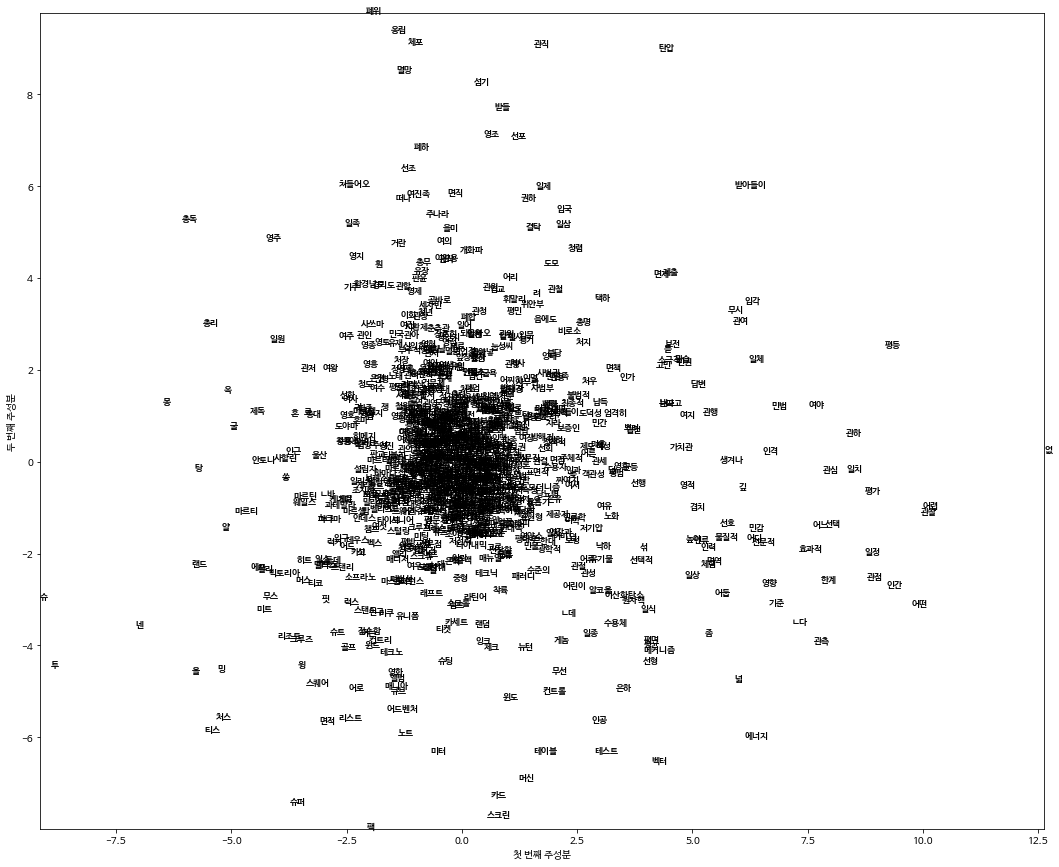

In [79]:
# PCA
show_pca()

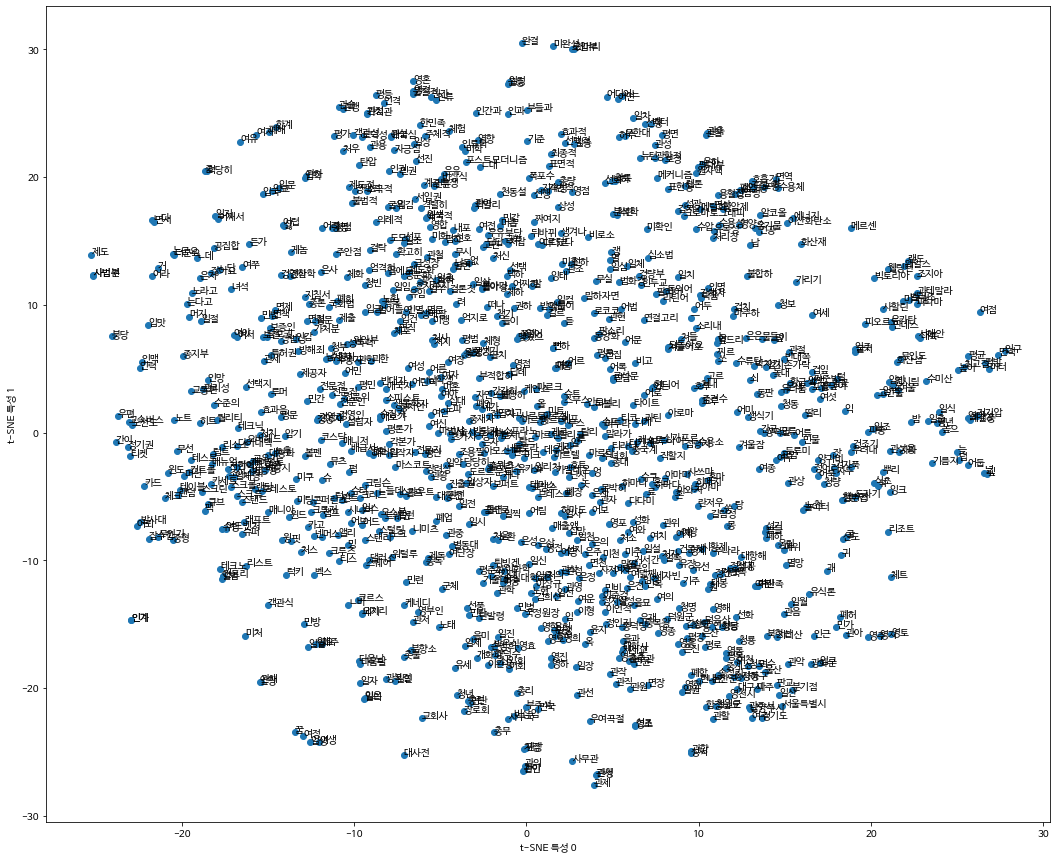

In [80]:
# t-SNE
show_tsne()

두 그래프를 확인해 보면, 연관 된 단어들끼리 모여 있는 것을 볼 수 있습니다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---

https://github.com/Kyubyong/wordvectors

In [54]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [55]:
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

- 5번에서 확인한 유사 단어들과는 다르게, 한국어 word2vec embedding을 활용한 결과, 유사하다고 판단할 수 있는 단어들이 출력 됨을 알 수 있었으며,

- 유사도는 0.59~0.72 사이로 높은 편은 아니지만, 단어의 의미를 살펴보면 어느정도 유사한 단어를 잘 출력하고 있다고 판단 할 수 있었습니다.

In [56]:
vocab_size = 10000 # 어휘 사전 크기
word_vector_dim = 200 # 워드 벡터 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [66]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)) # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
gru (GRU)                    (None, 41, 32)            22464     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 2,041,345
Trainable params: 2,041,345
Non-trainable params: 0
_________________________________________________________________


In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

opt = keras.optimizers.RMSprop(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es])

Epoch 1/10
266/266 [==============================] - 90s 320ms/step - loss: 0.6664 - accuracy: 0.5778 - val_loss: 0.5465 - val_accuracy: 0.7211
Epoch 2/10
266/266 [==============================] - 85s 320ms/step - loss: 0.5200 - accuracy: 0.7425 - val_loss: 0.4253 - val_accuracy: 0.8067
Epoch 3/10
266/266 [==============================] - 88s 332ms/step - loss: 0.4236 - accuracy: 0.8030 - val_loss: 0.3676 - val_accuracy: 0.8350
Epoch 4/10
266/266 [==============================] - 84s 317ms/step - loss: 0.3753 - accuracy: 0.8302 - val_loss: 0.3518 - val_accuracy: 0.8440
Epoch 5/10
266/266 [==============================] - 84s 316ms/step - loss: 0.3522 - accuracy: 0.8443 - val_loss: 0.3294 - val_accuracy: 0.8569
Epoch 6/10
266/266 [==============================] - 84s 315ms/step - loss: 0.3362 - accuracy: 0.8519 - val_loss: 0.3225 - val_accuracy: 0.8620
Epoch 7/10
266/266 [==============================] - 84s 315ms/step - loss: 0.3209 - accuracy: 0.8615 - val_loss: 0.3205 - val_ac

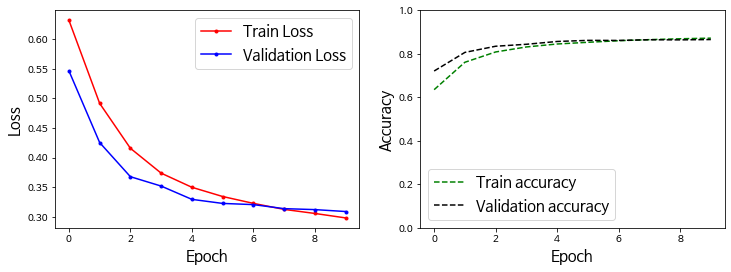

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)

plt.show()

In [71]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 34s - loss: 0.3171 - accuracy: 0.8618
[0.3171273469924927, 0.861769437789917]


최종적으로 '0.8618' 의 accuracy가 측정 되었음을 확인 할 수 있었습니다.

## 9) 리뷰 예측해보기
---

학습한 모델을 가지고, 새로운 문장을 긍정의 리뷰인지, 부정의 리뷰인지 예측을 진행해 보며 저느 정도의 정확도를 보이는 지 확인 해봅시다.

In [72]:
tokenizer = Mecab()


def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence) # encoding
    new_sentence = [new_sentence]

    new_sentence = keras.preprocessing.sequence.pad_sequences(new_sentence,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen)
    
    score = float(model.predict(new_sentence)) # 예측
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [73]:
sentiment_predict('영화는 재밌지만 배우가 연기를 너무 못하네요')

82.77% 확률로 부정 리뷰입니다.



In [74]:
sentiment_predict('영화가 너무 재밌네요')

77.93% 확률로 긍정 리뷰입니다.



In [75]:
sentiment_predict('조연 배우만 좋았다')

58.11% 확률로 부정 리뷰입니다.



In [76]:
sentiment_predict('발연기')

61.09% 확률로 부정 리뷰입니다.



In [77]:
sentiment_predict('킬링 타임용')

62.99% 확률로 부정 리뷰입니다.



대부분 맞게 예측을 하지만 은유적인 표현을 예측하는데 한계가 있는 것으로 보입니다.

프로젝트 평가문항
---

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
- 3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

# 9) 마무리 및 회고

- 노드를 진행하며 나와 있는 1-D CNN, GlobalMaxPooling, LSTM 의 3가지 이상의 모델로 구현을 하였으며, 추가적으로 LSTM에 어떤 옵티마이저가 가장 좋은지 적용해보고 훈련을 진행을 해본 결과 sjd, adam, RMSprop 중 RMSprop 가 가장 높은 성능을 보여 줌을 확인 할 수 있었습니다. 사실 cs231n을 공부하면서, 옵티마이저로서 adam을 사용하는 것이 디폴트값처럼 사용 했었는데, 이번 프로젝트를 진행하면서, LSTM 모델의 경우엔 RMSprop 옵티마이저가 적합하다는 것을 알 수 있었습니다.

- 사실 1-D CNN, GlobalMaxPooling 으로 정확도를 측정 했었을 때, 80 초중반 %가 나오길래 금방 85% 을 달성할 수 있을 줄 알았는데, LSTM 에서 다양한 옵티마이저로 진행 되어 있는 우수노드를 참고 () 해서 겨우 85%에 달성할 수 있었어서 개인적으로 어렵다는 생각이 들었습니다.

- ko.bin 불러오는데서 계속 에러가 나서 알아보니, 아지트 (https://aiffel.agit.io/g/300307137/wall/325639382) 에서 터미널에서 python을 다운그레이드를 하고, 쥬피터노트북을 셧다운 시키고 다시 시작을 해야 되는 과정을 진행해야한다는 것을 알려준 김성연님에게 여기에서 감사하다는 말씀을 드려보려고 합니다.

- 또한, 한국어 Word2Vec 임베딩 활용하면, 어떤 결과가 나오는 지 궁금했었는데 결과적으로 말하자면, 약 1% 정도의 정확도가 상승하는 것을 보고 언어에 따른 정확도가 차이가 있다라는 사실에 흥미롭다는 생각을 하였습니다.

- 개인적으로 이번 Exploration은 CV (컴퓨터 비전, 즉 이미지 처리) 는 CNN, NLP (자연어 처리)는 RNN으로 처리해야한다는 고정관념을 깨는 계기가 되었고, gensim 버전 이슈와 데이터 로드 에러 등의 다양한 시행착오를 겪어보고 이를 해결해보는 시간을 가지고 나서 한국어 Word2Vec 임베딩 시킨 뒤 85% 이상의 정확도를 뽑아내는 성능 개선을 이뤄냈다는 점에서 힘들기도 하였으나, 흥미로웠던 프로젝트로 기억에 남을 것 같습니다.

- 그리고, 개인적으로 CV와 NLP의 분야 중 관심 분야를 선택하지 않은 상태에서 다양한 툴을 사용해서 문제를 해결하는 이번 프로젝트를 통해서 앞으로 내가 선택할 분야가 어디인지 생각을 해보는 계기가 되어 의미 있었다고 생각합니다.

참고 레퍼런스
---
https://github.com/e9t/nsmc  
https://joyhong.tistory.com/133  
https://github.com/Kyubyong/wordvectors  
https://aiffel.agit.io/g/300307137/wall/325639382